In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from pointprocess import *
from lightning_setup import *
%matplotlib inline

EPK only because that is the area for which we have precipitable water data

In [2]:
c = Region(city=cities['cedar'])
c.SUBSETTED = False
c.CENTER = (37.7, -111.8)
c.RADIUS = 0.6
c.define_grid()

version1 = pd.HDFStore('./output/Version1/store.h5')

In [6]:
def dateparser(y, j, t):
    x = ' '.join([y, str(int(float(j))), t])
    return pd.datetime.strptime(x, '%Y %j %H:%M:%S')

df = pd.read_csv('./input/pwv147215720409387.txt', delim_whitespace=True, skiprows=[1], na_values=[-9.99],
                 parse_dates={'time': [1,2,3]}, date_parser=dateparser, index_col='time')

You only need to run the cell below if you haven't already calculated EPK_FC_2010_2015

In [7]:
%%time 

def get_FC(y):
    ds = c.get_ds(y=y, filter_CG=dict(method='less_than', amax=-10), func=None)
    df = ds.to_dataframe()
    ds.close()
    df.index = df.time
    FC = df['lat'].resample('24H', base=12, label='right').count()
    FC.name = 'FC'
    return FC

FC = get_FC(2010)
for y in range(2011,2016):
    FC = pd.concat([FC, get_FC(y)])

version1['EPK_FC_2010_2015'] = FC

CPU times: user 56.1 s, sys: 2.02 s, total: 58.1 s
Wall time: 1min 3s


In [6]:
IPW = df.resample('24H', base=12, label='right').mean()['IPW']

In [14]:
EPK_FC = version1['EPK_FC_2010_2015']
EPK_ngrids = c.gridx.shape[0]*c.gridy.shape[0]

# convert counts to density
df = pd.concat([IPW, EPK_FC], axis=1)
df.columns = ['IPW', 'FD']

# the data really should end in Sept 2015 when we run out of lightning data
df = df[:EPK_FC.index[-1]]

# NAN values should really be zeros
df['FD'] = df['FD'].fillna(0)

df.tail()

,IPW,FD
time,,
2015-09-26 12:00:00,1.307917,0.0
2015-09-27 12:00:00,1.343542,0.0
2015-09-28 12:00:00,1.733542,0.0
2015-09-29 12:00:00,2.184545,10.0
2015-09-30 12:00:00,2.085111,4.0


In [138]:
# convert to 0,1 with a threshold equal to 10 events per year
thresh = df.FD.sort_values(ascending=False)[50]

In [143]:
df['FD'][df['FD'] > thresh] = 1
df['FD'][df['FD'] <= thresh] = 0

here is an example of the data.set:

    "YYYY","MM","DD","START","STOP","EVENT","X1","X2"
    "1988","11","03",33,34,0,1.31938140222385,42.7067722733137
    "1988","11","04",34,35,0,0,44.0261536755376
    
I work at the daily scale and consider the water year as my “patient”: this is why November 3rd has a start of 33 and an end of 34, November 4th has a start of 34 and an end of 35. “Event” is the success/failure (“1” if you have an event and “0” if you don’t).

In [15]:
from collections import OrderedDict

d = {'YYYY': df.index.year,
     'MM': df.index.month,
     'DD': df.index.day,
     'START': df.index.dayofyear-1,  # start at 0
     'STOP': df.index.dayofyear,
     'EVENT': df['FD'],  
     'X1': df['IPW']}

OD = OrderedDict([(k, d[k]) for k in ['YYYY', 'MM', 'DD', 'START', 'STOP', 'EVENT', 'X1']])
cox_df = pd.DataFrame(OD)

# if we want to do something about missing values, we can try interpolating. 
# cox_df = cox_df.interpolate()

cox_df.to_csv('cox_test.csv', index=False)

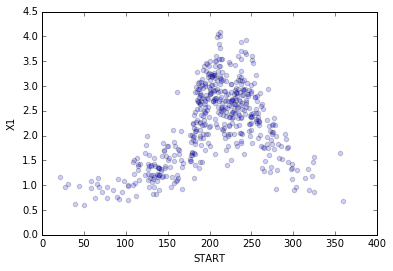

In [13]:
cox_df[cox_df['EVENT']>0].plot.scatter(y='X1', x='START', alpha=.2)

In [17]:
(cox_df['EVENT'] ==1).sum()

26

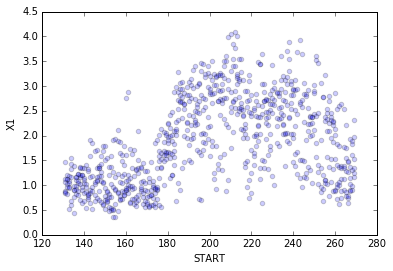

In [158]:
cox_df[(cox_df['START']>130) & (cox_df['START']<270)].plot.scatter(y='X1', x='START', alpha=.2)